In [1]:
# Cell 1: Imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Core parameters (edit these live on camera if you want)
N = 100_000        # candidate space size
M = 1              # number of successful candidates
alpha = M / N

TRIALS = 500       # Monte Carlo runs
T = 2000           # detection threshold (approx failures needed to trip)
seed = 7
random.seed(seed)
np.random.seed(seed)

In [3]:
# Cell 3: Black-box oracle model
# We DO NOT implement an exploit. We model "success" as membership in a hidden set.
success_set = set(np.random.choice(np.arange(N), size=M, replace=False))

def oracle(x: int) -> int:
    return 1 if x in success_set else 0

In [4]:
# Cell 4: Detection model (simple, practical)
# Detection fires when cumulative failures exceed T.
def run_classical_trial():
    tried = set()
    failures = 0
    queries = 0

    while True:
        # uniform random search without replacement
        if len(tried) == N:
            return queries, failures, True  # exhausted (shouldn't happen with M>=1)
        x = random.randrange(N)
        if x in tried:
            continue
        tried.add(x)

        queries += 1
        if oracle(x) == 1:
            detected = failures >= T
            return queries, failures, detected
        else:
            failures += 1
            # detection can trigger before success
            if failures >= T:
                # attacker could stop; we record that they were detected before success
                # and keep going to find success for query comparison
                pass

In [5]:
# Cell 5: Quantum-assisted model (simulation of expected Grover query count)
# We simulate the *query complexity advantage*, not a physical exploit.
def expected_grover_queries(N, M=1):
    return int(math.ceil((math.pi/4) * math.sqrt(N / M)))

Qq = expected_grover_queries(N, M)

def run_quantum_trial():
    # In a Grover-style model, attacker needs ~Qq oracle queries.
    # Failures are queries that do not hit success before the last query.
    # We'll model "success occurs by Qq" and approximate failures ~ (Qq-1).
    queries = Qq
    failures = max(0, Qq - 1)
    detected = failures >= T
    return queries, failures, detected

In [6]:
# Cell 6: Run Monte Carlo
classical = [run_classical_trial() for _ in range(TRIALS)]
quantum   = [run_quantum_trial()   for _ in range(TRIALS)]

c_q = np.array([x[0] for x in classical])
c_f = np.array([x[1] for x in classical])
c_d = np.array([x[2] for x in classical], dtype=int)

q_q = np.array([x[0] for x in quantum])
q_f = np.array([x[1] for x in quantum])
q_d = np.array([x[2] for x in quantum], dtype=int)

print("Classical median queries:", int(np.median(c_q)))
print("Quantum   median queries:", int(np.median(q_q)))
print("Speedup factor (median):", float(np.median(c_q) / np.median(q_q)))
print("Detection rate classical:", float(np.mean(c_d)))
print("Detection rate quantum:  ", float(np.mean(q_d)))

Classical median queries: 46985
Quantum   median queries: 249
Speedup factor (median): 188.69477911646587
Detection rate classical: 0.972
Detection rate quantum:   0.0


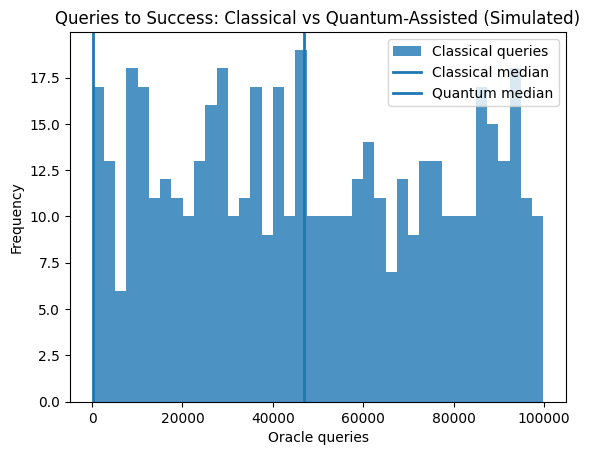

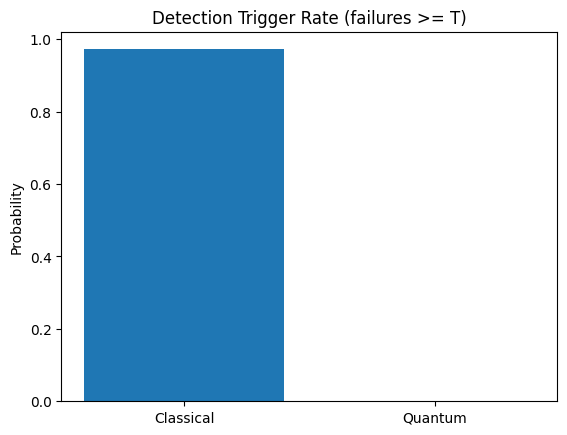

In [7]:
# Cell 7: Visuals (clear advantage)
plt.figure()
plt.hist(c_q, bins=40, alpha=0.8, label="Classical queries")
plt.axvline(np.median(c_q), linewidth=2, label="Classical median")
plt.axvline(np.median(q_q), linewidth=2, label="Quantum median")
plt.legend()
plt.title("Queries to Success: Classical vs Quantum-Assisted (Simulated)")
plt.xlabel("Oracle queries")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.bar(["Classical", "Quantum"], [np.mean(c_d), np.mean(q_d)])
plt.title("Detection Trigger Rate (failures >= T)")
plt.ylabel("Probability")
plt.show()

N | E[Q_class] | E[Q_quant] | speedup
103 103 8 12.88
104 104 9 11.56
105 105 9 11.67
106 106 9 11.78


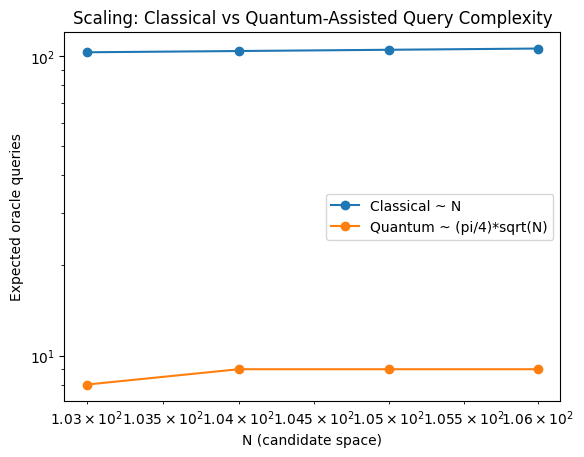

In [8]:
# Cell 8: Sensitivity sweep (this is the money shot)
Ns = [10_3, 10_4, 10_5, 10_6]
rows = []
for NN in Ns:
    QqNN = expected_grover_queries(NN, M=1)
    classical_expected = NN  # expected with M=1
    rows.append((NN, classical_expected, QqNN, classical_expected / QqNN))

print("N | E[Q_class] | E[Q_quant] | speedup")
for r in rows:
    print(r[0], r[1], r[2], round(r[3], 2))

plt.figure()
plt.plot([r[0] for r in rows], [r[1] for r in rows], marker="o", label="Classical ~ N")
plt.plot([r[0] for r in rows], [r[2] for r in rows], marker="o", label="Quantum ~ (pi/4)*sqrt(N)")
plt.xscale("log"); plt.yscale("log")
plt.title("Scaling: Classical vs Quantum-Assisted Query Complexity")
plt.xlabel("N (candidate space)")
plt.ylabel("Expected oracle queries")
plt.legend()
plt.show()